# Experiment with Flow Cytometry data and UMAP

This is a short notebook to experiment with running UMAP on flow cytometry data.
I am a mathematician and don't know much at all about this sort of data, so
please forgive any poor preprocessing or data handling. The main goal
was to experiment with running UMAP on this sort of data.

We'll need basic tools like numpy and pandas and the fcsparser library for
reading in the data.

In [1]:
import numpy as np
import pandas as pd
import fcsparser

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import umap
import MulticoreTSNE
import fitsne
import LargeVis
import sklearn.manifold

In [2]:
sns.set(context='poster', style='white', rc={'figure.figsize':(14,12)})

We can parse the data straight from the binary fcs file with fcsparser ...

In [3]:
fcs_data = fcsparser.parse('pbmc_luca.fcs')

The actual data is stored in the second element of the tuple (index 1); the first element
is header information.

In [4]:
raw_data = fcs_data[1]

The data is a pandas dataframe, which we'll do some further processing on...

In [5]:
raw_data.head()

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Alexa Fluor 488-A,PerCP-Cy5-5-A,APC-A,APC-Cy7-A,...,Alexa Fluor 430-A,Qdot 605-A,Qdot 655-A,Qdot 800-A,PE-A,PE-Texas Red-A,PE-Cy5-A,PE-Cy5-5-A,PE-Cy7-A,Time
0,156596.406250,130489.0,78648.031250,158078.781250,137410.0,75393.718750,168.100006,2204.979980,109.440002,210.520004,...,3536.830078,3257.960205,1847.810059,1491.520020,34.50,348.00,76.50,3511.50,768.75,0.0
1,38109.601562,37606.0,66413.625000,16372.939453,16342.0,65660.070312,-9.020000,92.659996,12.160000,45.599998,...,19.750000,22.910000,61.620003,139.830002,9.00,5.25,0.75,-276.75,46.50,0.0
2,30020.400391,29306.0,67133.593750,30577.798828,30090.0,66598.429688,-17.219999,10.660000,53.200001,16.719999,...,-45.820000,-97.959999,-112.180000,-105.070000,-10.50,26.25,-8.25,-654.75,141.00,0.0
3,108707.046875,96101.0,74132.679688,62743.121094,59173.0,69490.031250,43.459999,1671.979980,461.320007,-2.280000,...,244.110001,1098.099976,18294.820312,282.029999,140.25,341.25,524.25,6642.75,279.00,0.0
4,117901.445312,105719.0,73087.992188,49619.839844,46468.0,69981.187500,29.520000,1517.000000,414.959991,56.239998,...,182.490005,650.170044,21616.771484,24.490000,85.50,229.50,540.00,6021.00,234.75,0.1


We want a subset of the columns (I think these are the right ones), and standard preprocessing
of this sort of data seems to involve dividing through and applying arcsinh.

We will also cast the data to float32 and then select the first 200,000 rows. This
is likely not the best subsampling method, but it will suffice for quick experiments.

In [6]:
selected_columns = [col for col in raw_data.columns if col.endswith("-A")] + ['Time']
prepped_data = np.arcsinh(raw_data[selected_columns].values / 150.0).astype(np.float32, order='C')[:100000]

In [7]:
prepped_data.shape

(100000, 17)

## UMAP

In [8]:
%time e_umap = umap.UMAP(random_state=42).fit_transform(prepped_data)

CPU times: user 1min 52s, sys: 8.64 s, total: 2min 1s
Wall time: 1min 42s


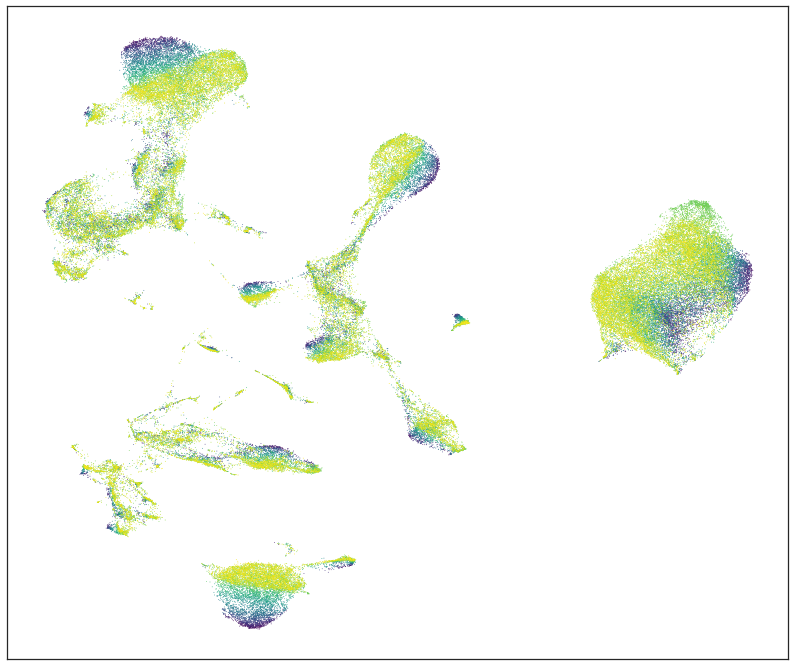

In [9]:
plt.scatter(*e_umap.T, s=0.1, c=prepped_data[:, -1], cmap='viridis')
plt.setp(plt.gca(), xticks=[], yticks=[]);

In [10]:
np.save('umap_flow_embedding1.npy', e_umap)

In [11]:
output = pd.DataFrame(e_umap, columns=('x','y'))
output['labels']=prepped_data[:, -1]
output.to_csv('embedding_flow_umap1.csv')

## FIt-SNE

In [12]:
%time e_fitsne = fitsne.FItSNE(prepped_data.astype(np.double), rand_seed=42, nthreads=1)

CPU times: user 2min 35s, sys: 9.76 s, total: 2min 44s
Wall time: 2min 44s


[]

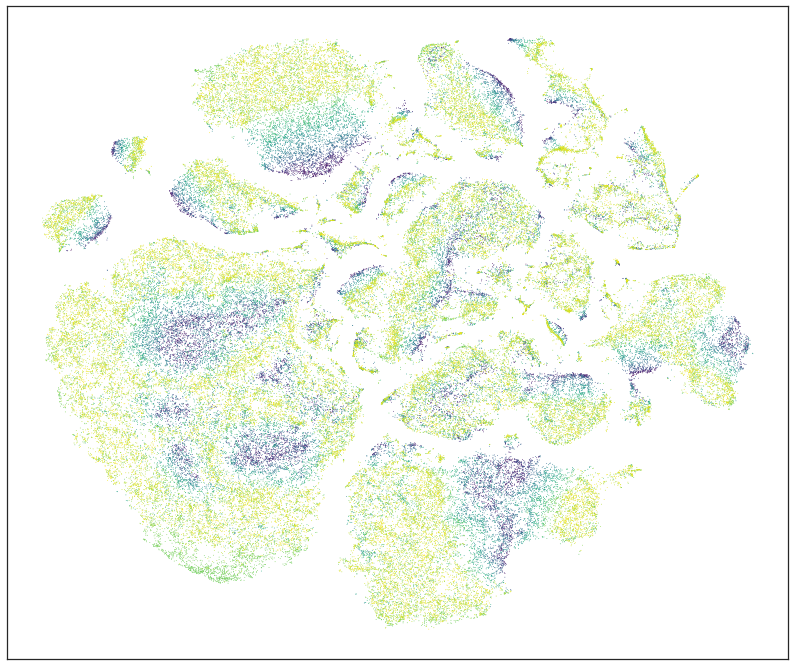

In [13]:
plt.scatter(*e_fitsne.T, s=0.1, c=prepped_data[:, -1], cmap='viridis')
plt.setp(plt.gca(), xticks=[], yticks=[])

In [14]:
np.save('fitsne_flow_embedding1.npy', e_fitsne)

In [15]:
output = pd.DataFrame(e_fitsne, columns=('x','y'))
output['labels']=prepped_data[:, -1]
output.to_csv('embedding_flow_fitsne1.csv')

## t-SNE

In [16]:
%time e_tsne = MulticoreTSNE.MulticoreTSNE(random_state=42, n_jobs=1).fit_transform(prepped_data)

CPU times: user 18min 30s, sys: 24.8 s, total: 18min 55s
Wall time: 18min 55s


[]

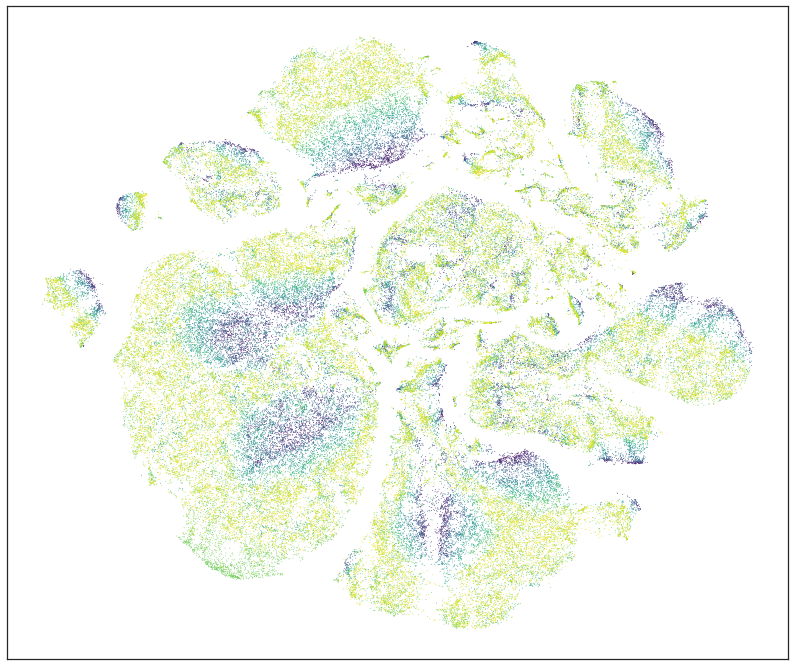

In [17]:
plt.scatter(*e_tsne.T, s=0.1, c=prepped_data[:, -1], cmap='viridis')
plt.setp(plt.gca(), xticks=[], yticks=[])

In [18]:
np.save('tsne_flow_embedding1.npy', e_tsne)

In [19]:
output = pd.DataFrame(e_tsne, columns=('x','y'))
output['labels']=prepped_data[:, -1]
output.to_csv('embedding_flow_tsne1.csv')

## LargeVis

In [20]:
largevis_data = prepped_data.astype(np.float32, order='C')
LargeVis.loadarray(largevis_data)
largevis_n_samples = int(largevis_data.shape[0] / 100.0)

In [21]:
%time e_largevis = LargeVis.run(2, 1, largevis_n_samples)

CPU times: user 18min 45s, sys: 6.9 s, total: 18min 52s
Wall time: 18min 47s


[]

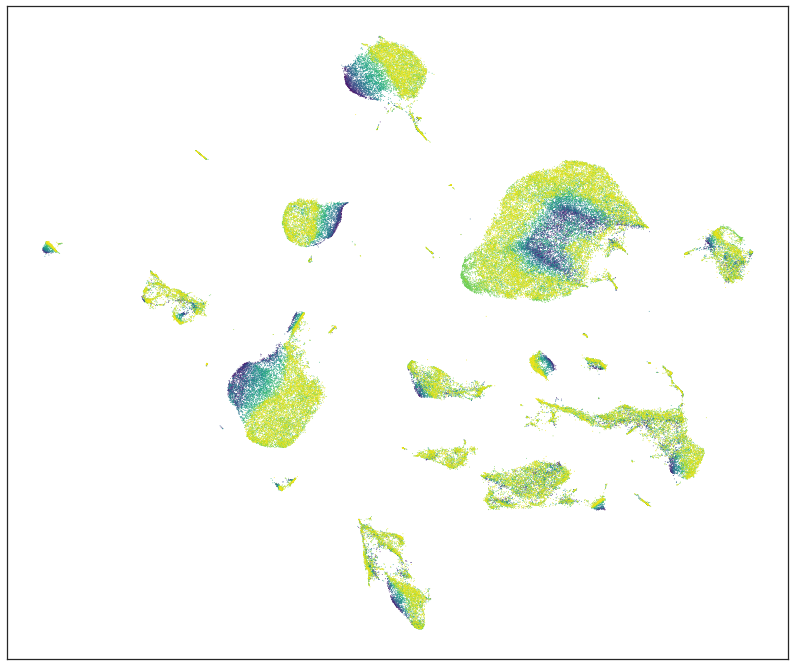

In [22]:
plt.scatter(*np.array(e_largevis).T, s=0.1, c=prepped_data[:, -1], cmap='viridis')
plt.setp(plt.gca(), xticks=[], yticks=[])

In [23]:
np.save('largevis_flow_embedding1.npy', e_largevis)

In [24]:
output = pd.DataFrame(e_largevis, columns=('x','y'))
output['labels']=prepped_data[:, -1]
output.to_csv('embedding_flow_largevis1.csv')

## Laplacian Eigenmaps

In [25]:
%time e_eigenmaps = sklearn.manifold.SpectralEmbedding(n_neighbors=15).fit_transform(prepped_data)

CPU times: user 4h 14min 1s, sys: 2h 7min 22s, total: 6h 21min 24s
Wall time: 8h 30min 54s


[]

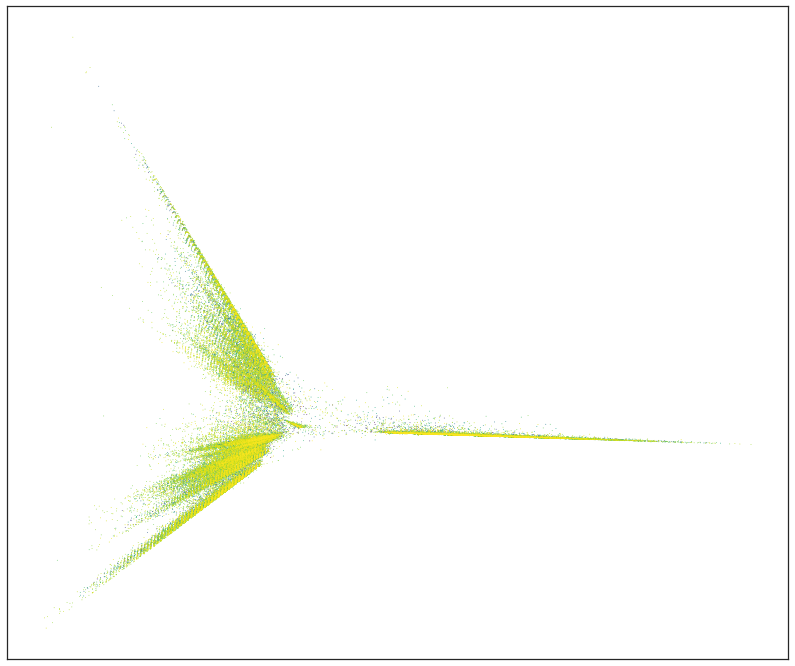

In [26]:
plt.scatter(*e_eigenmaps.T, s=0.1, c=prepped_data[:, -1], cmap='viridis')
plt.setp(plt.gca(), xticks=[], yticks=[])

In [27]:
np.save('eigenmaps_flow_embedding1.npy', e_eigenmaps)

In [ ]:
output = pd.DataFrame(e_eigenmaps, columns=('x','y'))
output['labels']=prepped_data[:, -1]
output.to_csv('embedding_flow_eigenmaps1.csv')

## Isomap

In [ ]:
%time e_isomap = sklearn.manifold.Isomap().fit_transform(prepped_data)

In [ ]:
plt.scatter(*e_isomap.T, s=0.1, c=prepped_data[:, -1], cmap='viridis')
plt.setp(plt.gca(), xticks=[], yticks=[])

In [ ]:
np.save('isomap_flow_embedding1.npy', e_isomap)

In [ ]:
output = pd.DataFrame(e_isomap, columns=('x','y'))
output['labels']=prepped_data[:, -1]
output.to_csv('embedding_flow_isomap1.csv')